# How to train and tune a random forest

In [6]:
# @title Import Packages
import warnings
warnings.filterwarnings('ignore')

from __future__ import division, print_function, unicode_literals

%matplotlib inline

from pathlib import Path
import os, sys
import numpy as np

from numpy.random import choice
import pandas as pd
from scipy.stats import spearmanr

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
## 1.Setup
#First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:
# To support both python 2 and python 3
import warnings
warnings.filterwarnings("ignore")
# Common imports
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from pathlib import Path
import requests
from io import BytesIO
from zipfile import ZipFile, BadZipFile

import numpy as np
import pandas as pd
import pandas_datareader.data as web

In [5]:
! pip install pandas_datareader

  Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)


In [ ]:
# @title   # First step: Collect data
# Data comes from FRED
# https://fred.stlouisfed.org/


securities = {'BAMLCC0A0CMTRIV'   : 'US Corp Master TRI',
              'BAMLHYH0A0HYM2TRIV': 'US High Yield TRI',
              #'BAMLEMCBPITRIV'    : 'Emerging Markets Corporate Plus TRI',
              #'GOLDAMGBD228NLBM'  : 'Gold (London, USD)',
              'DGS10'             : '10-Year Treasury CMR',
              }
df = web.DataReader(name=list(securities.keys()), data_source='fred', start=2000)
df = df.rename(columns=securities).dropna(how='all').resample('B').mean()


#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
np.random.seed(42)

def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'


class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates[self.date_idx] <= days[train_end])].index
            test_idx = dates[(dates[self.date_idx] > days[test_start])
                             & (dates[self.date_idx] <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


sys.path.insert(1, os.path.join(sys.path[0], '..'))
#from utils import MultipleTimeSeriesCV

sns.set_style('white')
np.random.seed(seed=42)

results_path = Path('results', 'random_forest')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Get Data Overview:

In [ ]:
df.columns

Index(['US Corp Master TRI', 'US High Yield TRI', '10-Year Treasury CMR'], dtype='object')

In [ ]:
df.head()

,US Corp Master TRI,US High Yield TRI,10-Year Treasury CMR
DATE,,,
2000-01-03,991.58,363.62,6.58
2000-01-04,995.74,363.04,6.49
2000-01-05,990.59,362.31,6.62
2000-01-06,993.67,362.42,6.57
2000-01-07,995.12,362.46,6.52


## Choose Target Data to Predict

In [ ]:
# @title Target Data to Predict
data = df.copy()

#data = data[["10-Year Treasury CMR","US High Yield TRI","Gold (London, USD)"]]
target = "10-Year Treasury CMR" # what to predict here
data["target"] = data[target]
data = data.drop(target,axis=1)
data.head()

,US Corp Master TRI,US High Yield TRI,target
DATE,,,
2000-01-03,991.58,363.62,6.58
2000-01-04,995.74,363.04,6.49
2000-01-05,990.59,362.31,6.62
2000-01-06,993.67,362.42,6.57
2000-01-07,995.12,362.46,6.52


In [ ]:
data["target"]= data["target"].shift(-1)
data.index.name ="date"
data.head()

,US Corp Master TRI,US High Yield TRI,target
date,,,
2000-01-03,991.58,363.62,6.49
2000-01-04,995.74,363.04,6.62
2000-01-05,990.59,362.31,6.57
2000-01-06,993.67,362.42,6.52
2000-01-07,995.12,362.46,6.57


<Axes: xlabel='date'>

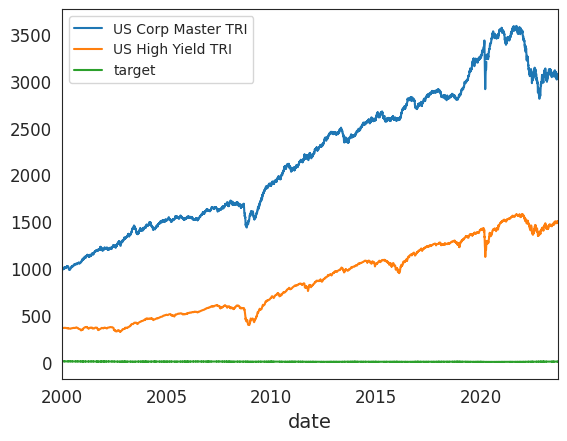

In [ ]:
# Plot the data in a time series
data.plot()

<Axes: xlabel='date'>

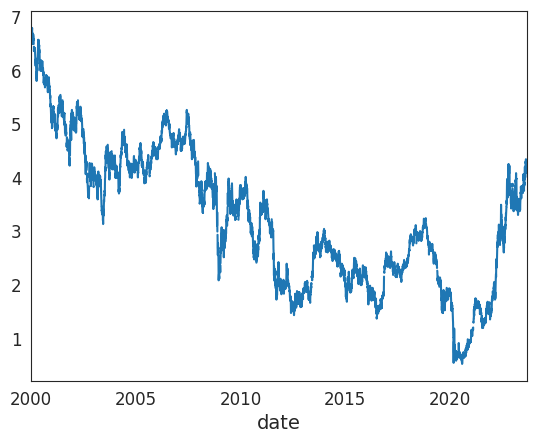

In [ ]:
# Visualize target variable
data["target"].plot()

In [ ]:
# create returns from prices
daily_returns = data.pct_change(1)
daily_returns = daily_returns[2:(len(daily_returns)-1)]
daily_returns.tail()

,US Corp Master TRI,US High Yield TRI,target
date,,,
2023-09-01,-0.005256,-0.000193,0.000000
2023-09-04,0.000363,0.000546,0.021531
2023-09-05,-0.005330,-0.002933,0.007026
2023-09-06,-0.001711,-0.002535,-0.006977
2023-09-07,0.002520,0.000796,-0.002342


<Axes: xlabel='date'>

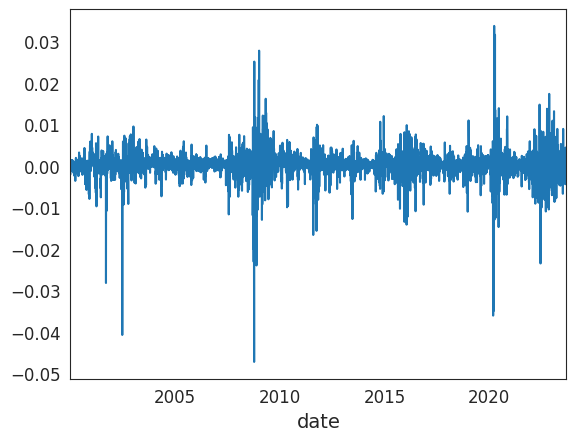

In [ ]:
# Plot the daily returns
daily_returns["US High Yield TRI"].plot()

In [ ]:
# @title Get Y_binary variable
y = daily_returns.target
y_binary = (y > 0).astype(int)
X = pd.get_dummies(daily_returns.drop('target', axis=1))
y_binary

date
2000-01-05    0
2000-01-06    0
2000-01-07    1
2000-01-10    1
2000-01-11    1
             ..
2023-09-01    0
2023-09-04    1
2023-09-05    1
2023-09-06    0
2023-09-07    0
Freq: B, Name: target, Length: 6177, dtype: int64

In [ ]:
# @title Retrieve X_variables
X.head()

,US Corp Master TRI,US High Yield TRI
date,,
2000-01-05,-0.005172,-0.002011
2000-01-06,0.003109,0.000304
2000-01-07,0.001459,0.000110
2000-01-10,-0.000864,0.000745
2000-01-11,-0.004043,-0.000910


In [ ]:
# @title Split data into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, random_state=42)

## Random Forests

In [ ]:
X_train

,US Corp Master TRI,US High Yield TRI
date,,
2013-11-26,0.002908,0.000729
2009-10-05,0.000734,0.002211
2012-02-21,-0.001059,0.001074
2023-01-16,0.000334,0.000529
2009-07-09,-0.006991,-0.001845
...,...,...
2014-06-20,0.000343,0.000862
2019-11-28,0.000000,0.000000
2020-01-16,-0.000436,0.000612


In [ ]:
y_train

date
2013-11-26    1
2009-10-05    1
2012-02-21    0
2023-01-16    1
2009-07-09    0
             ..
2014-06-20    0
2019-11-28    1
2020-01-16    1
2020-09-02    0
2003-04-23    0
Name: target, Length: 4632, dtype: int64

In [ ]:
# @title Fit the Decision tree to the training data

tree_clf = DecisionTreeClassifier(max_depth=3)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_train)
print("in sample", accuracy_score(y_train, y_pred))
y_pred = tree_clf.predict(X_test)
print("out-of-sample", accuracy_score(y_test, y_pred))

in sample 0.5841968911917098
out-of-sample 0.5495145631067961


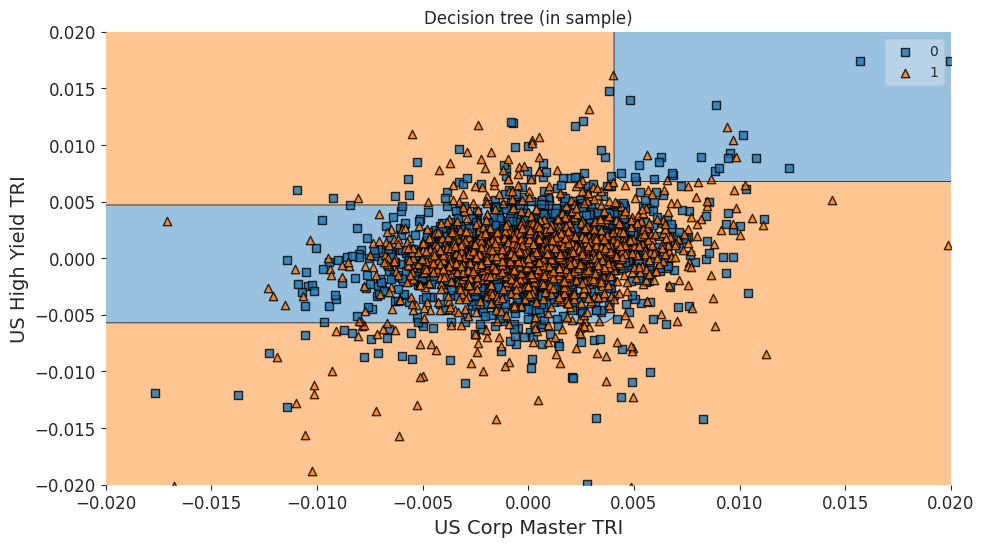

In [ ]:
# @title Plot the decision boundary
try:
  plt.figure(figsize=(24,20))
  plt.subplot(321)
  plt.xlim([-0.1,0.1])
  plot_decision_regions(X_train.values, y_train.values, tree_clf)
  plt.title("Decision tree (in sample)")
  plt.xlabel(X_train.columns[0])
  plt.ylabel(X_train.columns[1])
  plt.xlim([-0.02,0.02])
  plt.ylim([-0.02,0.02])
  plt.show()
except:
  print("you probably have high-dimensional data")

In [ ]:
# @title Fit Random Forest
# fit the model to the training data
rf_clf = RandomForestClassifier(n_estimators=20, random_state=3, max_leaf_nodes =640)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_train)
print("in sample", accuracy_score(y_train, y_pred))
y_pred = rf_clf.predict(X_test)
print("out-of-sample", accuracy_score(y_test, y_pred))

in sample 0.9214162348877375
out-of-sample 0.510032362459547


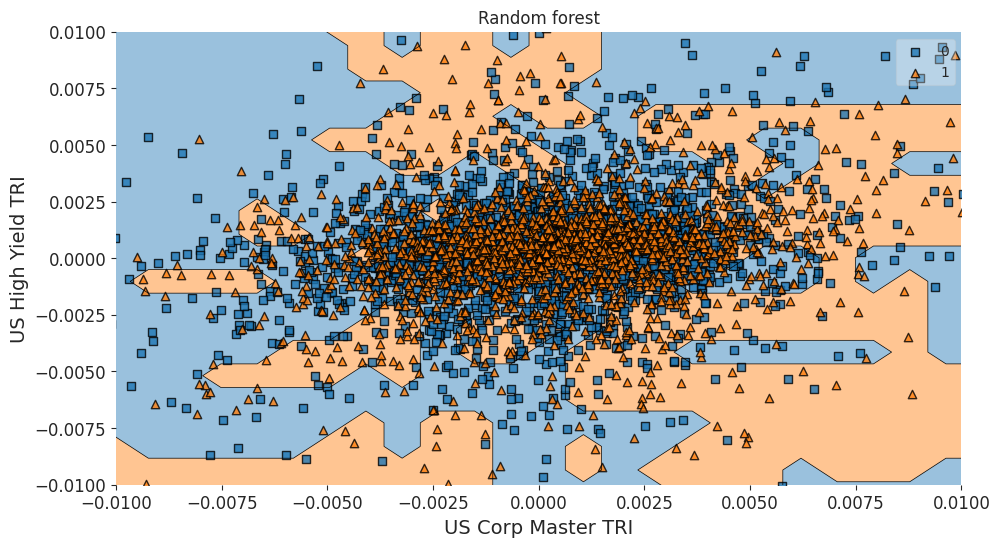

In [ ]:
# @title Plot the decision boundary
try:
  plt.figure(figsize=(24,20))
  plt.subplot(321)
  plt.xlim([-0.1,0.1])
  plot_decision_regions(X_train.values, y_train.values, rf_clf)
  plt.title("Random forest")
  plt.xlabel(X_train.columns[0])
  plt.ylabel(X_train.columns[1])
  plt.xlim([-0.01,0.01])
  plt.ylim([-0.01,0.01])
  plt.show()
except:
  print("you probably have high-dimensional data")

### SVC forecast

In [ ]:
# @title Fit the SVC model to the training data
svc_clf = SVC(kernel="linear")
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_train)
print("in sample", accuracy_score(y_train, y_pred))
y_pred = svc_clf.predict(X_test)
print("out-of-sample", accuracy_score(y_test, y_pred))

in sample 0.5734024179620034
out-of-sample 0.568284789644013


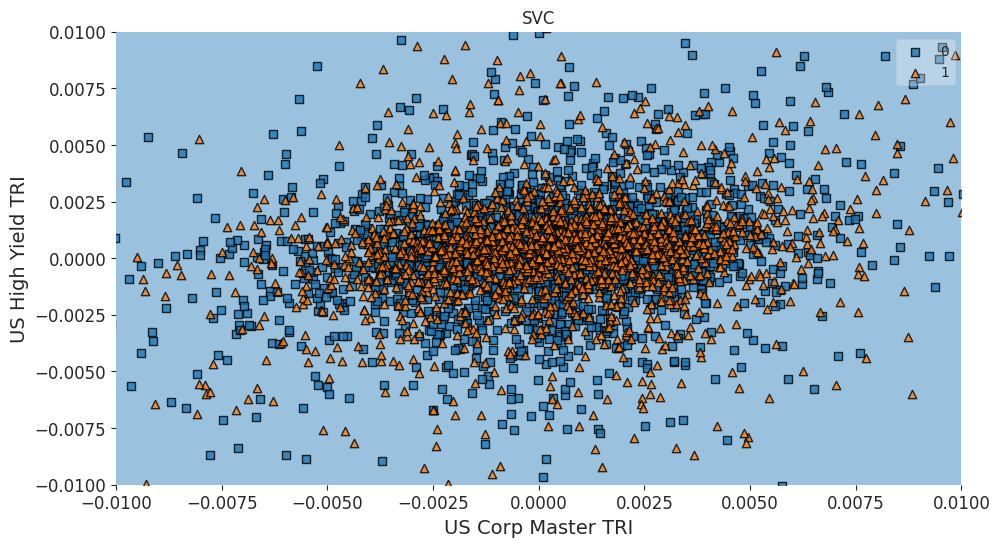

high-dimensional data


In [ ]:
# @title Plot the decision boundary
import matplotlib.pyplot as plt

plt.figure(figsize=(24,20))
plt.subplot(321)
plt.xlim([-0.1,0.1])
plot_decision_regions(X_train.values, y_train.values, svc_clf)
plt.title("SVC")
plt.xlabel(X_train.columns[0])
plt.ylabel(X_train.columns[1])
plt.xlim([-0.01,0.01])
plt.ylim([-0.01,0.01])
plt.show()
print("high-dimensional data")


### Cross Validation

In [ ]:
scores = cross_val_score(rf_clf, X, y_binary, cv=15)
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.53 accuracy with a standard deviation of 0.02


In [ ]:
scores

array([0.52912621, 0.54854369, 0.51699029, 0.51699029, 0.52669903,
       0.50485437, 0.54126214, 0.51213592, 0.53398058, 0.50242718,
       0.54854369, 0.5       , 0.51581509, 0.55961071, 0.53284672])

In [ ]:
# @title Regression RF
def rank_correl(y, y_pred):
    return spearmanr(y, y_pred)[0]

ic = make_scorer(rank_correl)

rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

## Parameter Tuning

The key configuration parameters include the various hyperparameters for the individual decision trees introduced in the notebook [decision_trees](01_decision_trees.ipynb).

The following tables lists additional options for the two `RandomForest` classes:

| Keyword      | Default | Description                                                                                                                |
|--------------|---------|----------------------------------------------------------------------------------------------------------------------------|
| bootstrap    | True    | Bootstrap samples during training                                                                                          |
| n_estimators | 10      | # trees in the forest.                                                                                                     |
| oob_score    | False   | Use out-of-bag samples to estimate the R2 on unseen data                                                                   |
| warm_start   | False   | Reuse result of previous call to continue training and add more trees to the ensemble, otherwise, train a whole new forest |

- The `bootstrap` parameter activates in the preceding bagging algorithm outline, which in turn enables the computation of the out-of-bag score (oob_score) that estimates the generalization accuracy using samples not included in the bootstrap sample used to train a given tree (see next section for detail).
- The `n_estimators` parameter defines the number of trees to be grown as part of the forest. Larger forests perform better, but also take more time to build. It is important to monitor the cross-validation error as a function of the number of base learners to identify when the marginal reduction of the prediction error declines and the cost of additional training begins to outweigh the benefits.
- The `max_features` parameter controls the size of the randomly selected feature subsets available when learning a new decision rule and split a node. A lower value reduces the correlation of the trees and, thus, the ensemble's variance, but may also increase the bias. Good starting values are `n_features` (the number of training features) for regression problems and `sqrt(n_features)` for classification problems, but will depend on the relationships among features and should be optimized using cross-validation.

Random forests are designed to contain deep fully-grown trees, which can be created using `max_depth=None` and `min_samples_split=2`. However, these values are not necessarily optimal, especially for high-dimensional data with many samples and, consequently, potentially very deep trees that can become very computationally-, and memory-, intensive.

The `RandomForest` class provided by sklearn support parallel training and prediction by setting the n_jobs parameter to the k number of jobs to run on different cores. The -1 value uses all available cores. The overhead of interprocess communication may limit the speedup from being linear so that k jobs may take more than 1/k the time of a single job. Nonetheless, the speedup is often quite significant for large forests or deep individual trees that may take a meaningful amount of time to train when the data is large, and split evaluation becomes costly.

As always, the best parameter configuration should be identified using cross-validation. The following steps illustrate the process:

### Define Parameter Grid

In [ ]:
param_grid = {'n_estimators': [50, 100, 250],
              'max_depth': [5, 15, None],
              'min_samples_leaf': [5, 25, 100]}

### Instantiate GridSearchCV

We will use 10-fold custom cross-validation and populate the parameter grid with values for the key configuration settings:

In [ ]:
gridsearch_clf = GridSearchCV(estimator=rf_clf,
                              param_grid=param_grid,
                              scoring='roc_auc',
                              n_jobs=-1,
                       #       cv=cv,
                              refit=True,
                              return_train_score=True,
                              verbose=1)

### Fit Classifier

In [ ]:
gridsearch_clf.fit(X=X, y=y_binary)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestClassifier(max_leaf_nodes=640,
                                              n_estimators=20, random_state=3),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring='roc_auc', verbose=1)

#### Persist Result

In [ ]:
joblib.dump(gridsearch_clf, results_path / 'gridsearch_clf.joblib')

['results/random_forest/gridsearch_clf.joblib']

In [ ]:
gridsearch_clf = joblib.load(results_path / 'gridsearch_clf.joblib')

In [ ]:
gridsearch_clf.best_params_

{'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 100}

In [ ]:
gridsearch_clf.best_score_

0.5182163933259064

#### Feature Importance

A random forest ensemble may contain hundreds of individual trees, but it is still possible to obtain an overall summary measure of feature importance from bagged models.

For a given feature, the importance score is the total reduction in the objective function's value, which results from splits based on this feature, averaged over all trees. Since the objective function takes into account how many features are affected by a split, this measure is implicitly a weighted average so that features used near the top of a tree will get higher scores due to the larger number of observations contained in the much smaller number of available nodes. By averaging over many trees grown in a randomized fashion, the feature importance estimate loses some variance and becomes more accurate.

The computation differs for classification and regression trees based on the different objectives used to learn the decision rules and is measured in terms of the mean square error for regression trees and the Gini index or entropy for classification trees.

`sklearn` further normalizes the feature-importance measure so that it sums up to 1. Feature importance thus computed is also used for feature selection as an alternative to the mutual information measures we saw in Chapter 6, The Machine Learning Process (see SelectFromModel in the sklearn.feature_selection module).
In our example, the importance values for the top-20 features are as shown here:

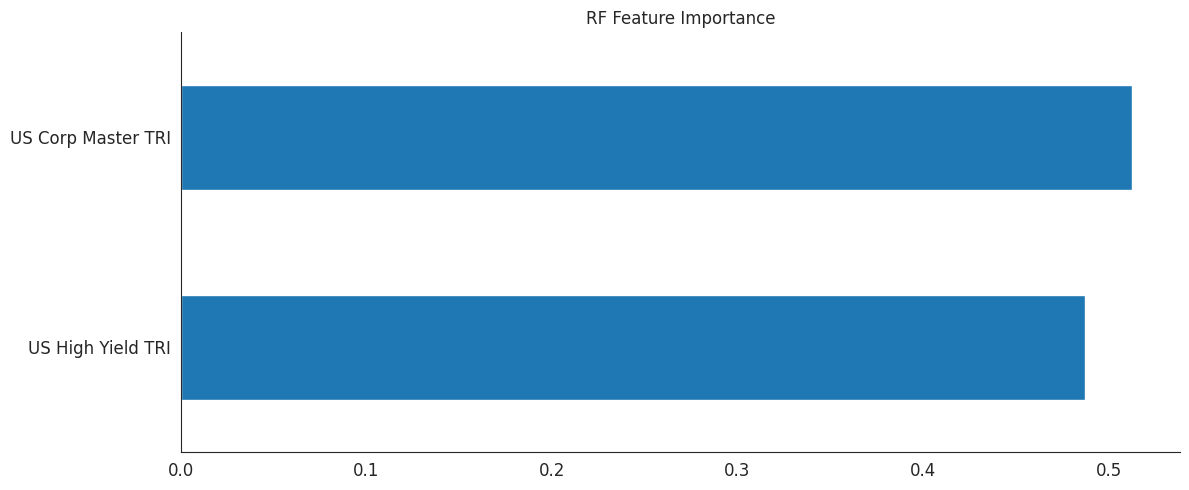

In [ ]:
# @title Plotting Feature Importance
fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(gridsearch_clf.best_estimator_.feature_importances_,
           index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='RF Feature Importance'))
sns.despine()
fig.tight_layout();

### Fit Regressor

In [ ]:
# @title Fitting Regressor
gridsearch_reg = GridSearchCV(estimator=rf_reg,
                      param_grid=param_grid,
                      scoring=ic,
                      n_jobs=-1,
                    #  cv=cv,
                      refit=True,
                      return_train_score=True,
                      verbose=1)

In [ ]:
gs_reg = gridsearch_reg

In [ ]:
gridsearch_reg.fit(X=X, y=y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestRegressor(max_features='auto', n_jobs=-1),
             n_jobs=-1,
             param_grid={'max_depth': [5, 15, None],
                         'min_samples_leaf': [5, 25, 100],
                         'n_estimators': [50, 100, 250]},
             return_train_score=True, scoring=make_scorer(rank_correl),
             verbose=1)

In [ ]:
joblib.dump(gridsearch_reg, results_path / 'rf_reg_gridsearch.joblib')

gridsearch_reg = joblib.load(results_path / 'rf_reg_gridsearch.joblib')

gridsearch_reg.best_params_

{'max_depth': 5, 'min_samples_leaf': 25, 'n_estimators': 250}

In [ ]:
f'{gridsearch_reg.best_score_*100:.2f}'

'2.03'

### Compare Results

#### Best Parameters

In [ ]:
pd.DataFrame({'Regression': pd.Series(gridsearch_reg.best_params_),
              'Classification': pd.Series(gridsearch_clf.best_params_)})

,Regression,Classification
max_depth,5,5
min_samples_leaf,25,5
n_estimators,250,100


#### Feature Importance

In [ ]:
fi_clf = gridsearch_clf.best_estimator_.feature_importances_
fi_reg = gridsearch_reg.best_estimator_.feature_importances_
idx = [c.replace('_', ' ').upper() for c in X.columns]

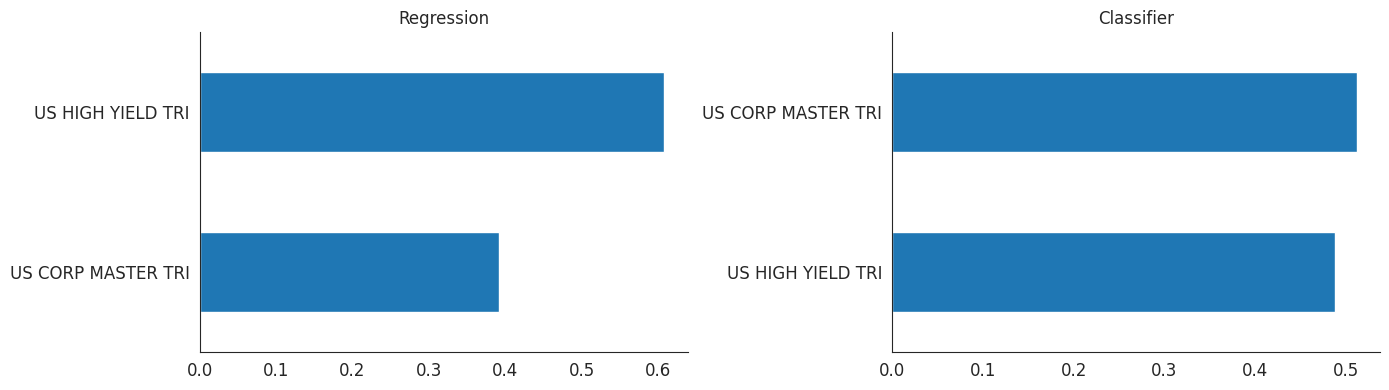

In [ ]:
# @title Plotting Regression and Classifier
fig, axes = plt.subplots(figsize=(14, 4), ncols=2)
(pd.Series(fi_clf, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[1], title='Classifier'))
(pd.Series(fi_reg, index=idx)
 .sort_values(ascending=False)
 .iloc[:15]
 .sort_values()
 .plot.barh(ax=axes[0], title='Regression'))
sns.despine()
fig.tight_layout()